In [65]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# Daily TSLA index for 10 years from 2013
# https://www.nasdaq.com/market-activity/index/tsla/historical  < NO! DOES NOT INC SPLIT ADJUSTED CLOSE! USE YAHOO!
# https://finance.yahoo.com/quote/TSLA/history?period1=1277769600&period2=1701907200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
# Select max date range and download csv file
csv_file = '../data/tsla_HistoricalData.csv'

df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Adj Close'])
df.head()

,Date,Adj Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000


In [67]:
df.rename(columns={'Price': 'Pre-split Price'}, inplace=True)
df.rename(columns={'Adj Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [68]:
csv_file = '../data/tsla_ArkInvestTarget.csv'
dforecast = pd.read_csv(csv_file)
dforecast['Date'] = pd.to_datetime(dforecast['TargetDate'],dayfirst=True)
dforecast.set_index('Date', inplace=True)
# split forward forecast from the main base lines (where ArkBear is NaN)
dforecastProjection = dforecast[dforecast['ForecastDate']=='14/04/2022']
dforecast = dforecast[dforecast['ArkBear'].notna()]
dforecast = dforecast.sort_index()
dforecastProjection.head()


,ArkInvest,ArkBear,ArkBase,ArkBull,ForecastDate,TargetDate,Note
Date,,,,,,,
2026-06-01,2026,966.666667,1533.333333,1933.333333,14/04/2022,1/06/2026,"added bitcoin, increased robotaxi"
2027-06-01,2027,NaN,2666.666667,NaN,14/04/2022,1/06/2027,forward forecast published with 2026 target
2028-06-01,2028,NaN,4666.666667,NaN,14/04/2022,1/06/2028,forward forecast published with 2026 target
2029-06-01,2029,NaN,6333.333333,NaN,14/04/2022,1/06/2029,forward forecast published with 2026 target
2030-06-01,2030,NaN,7500.000000,NaN,14/04/2022,1/06/2030,forward forecast published with 2026 target


In [69]:
csv_file = '../data/tsla_OtherTarget.csv'
dfOther = pd.read_csv(csv_file)
dfOther['Date'] = pd.to_datetime(dfOther['TargetDate'],dayfirst=True)
dfOther.set_index('Date', inplace=True)
dfOther = dfOther.sort_index()
dfOther.head()
print(dfOther.columns)

Index(['Year', 'Source', 'Bear', 'Base', 'Bull', 'ForecastDate', 'TargetDate',
       'Note'],
      dtype='object')


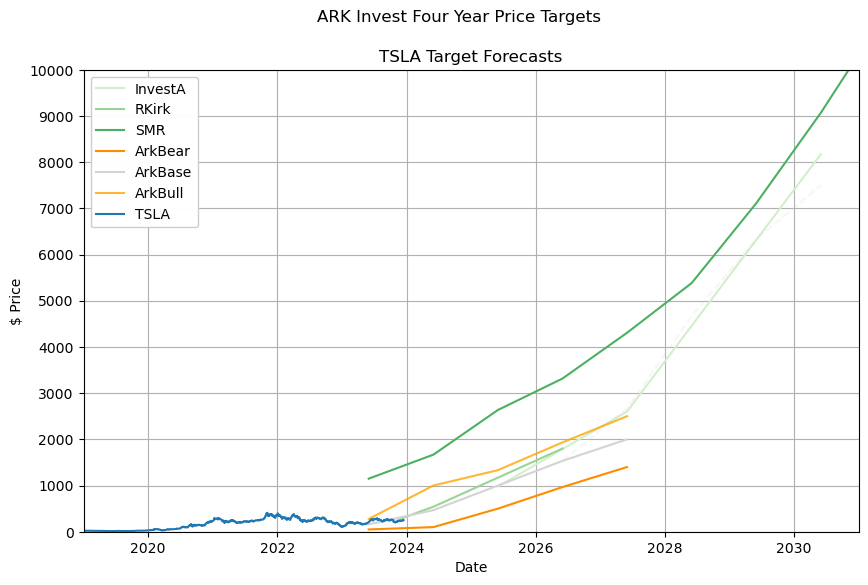

In [85]:
import matplotlib.cm as cm
import numpy as np
plt.figure(figsize=(10, 6))
grouped = dfOther.groupby('Source')
colors = plt.cm.Greens(np.linspace(0.2, 0.6, len(grouped)))
for (name, group), color in zip(grouped, colors):
    plt.plot(group.index, group['Base'], label=name, color=color)

plt.plot(dforecast.index, dforecast['ArkBear'], color='darkorange', label='ArkBear')
plt.plot(dforecast.index, dforecast['ArkBase'], color = 'lightgrey', label='ArkBase')
plt.plot(dforecastProjection.index, dforecastProjection['ArkBase'], color = 'lightgrey', alpha=0.2, linestyle='--')
plt.plot(dforecast.index, dforecast['ArkBull'], color='orange', label='ArkBull', alpha=0.8)

colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Price'], color=colors[0]['color'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('ARK Invest Four Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(range(0, 100000, 1000))
plt.grid(True)
plt.ylim(bottom=0, top=10000) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=pd.to_datetime('2031-01-01'))
#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()